In [ ]:
Полина чижик , вариант 1 Метод активации - Tanh Шаг градиентного спуска - 0.01

Задание 1

Свертка - операция, которая лежит в основе реализации сверточных сетей. 
Неформально эту операцию можно описать следующим образом — окном размера ядра g проходим с заданным шагом (обычно 1) все изображение f, на каждом шаге поэлементно умножаем содержимое окна на ядро g, результат суммируется и записывается в матрицу результата

Паддинг - добавляет к краям изображения поддельные пиксели. 
Таким образом, ядро при проскальзывании позволяет неподдельным пикселям оказываться в своем центре, а затем распространяется на поддельные пиксели за пределами края, создавая выходную матрицу того же размера, что и входная.

Страйд - идея страйда заключается в том, чтобы пропустить некоторые области, над которыми скользит ядро. Шаг 1 означает, что берутся пролеты через пиксель, то есть по факту каждый пролет является стандартной сверткой. Шаг 2 означает, что пролеты совершаются через каждые два пикселя, пропуская все другие пролеты в процессе и уменьшая их количество примерно в 2 раза, шаг 3 означает пропуск 3-х пикселей, сокращая количество в 3 раза и т.д.

average_pooling, max_pooling - пулинговый слой призван снижать размерность изображения.
Исходное изображение делится на блоки размером w×h и для каждого блока вычисляется некоторая функция. 
Чаще всего используется функция максимума (max pooling) или (взвешенного) среднего (average pooling)


In [2]:
import torch
import random
import numpy as np
import pandas as pd
import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

d:\python\projects_384\po\venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\python\projects_384\po\venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\python\projects_384\po\venv\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
d:\python\projects_384\po\venv\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
len(y_train), len(y_test)

(60000, 10000)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

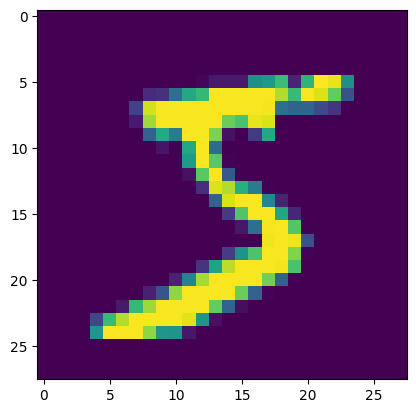

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self, n_layers = 1, activation = 'tanh', pooling = 'average'):
        super(LeNet5, self).__init__()
        
        if activation == 'tanh':
            act = torch.nn.Tanh()
        elif activation == 'relu':
            act = torch.nn.ReLU()
            
        if pooling == 'average':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        feature_extractor = torch.nn.Sequential()
        feature_extractor.add_module('conv_input',torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2))
        feature_extractor.add_module('activation_input',act)
        feature_extractor.add_module('pooling1',pooling_layer)
        for i in range(n_layers):
            feature_extractor.add_module(f'conv_{i}',torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=5, padding=2))
            feature_extractor.add_module(f'activation_{i}',act)
        feature_extractor.add_module('conv_last',torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0))
        feature_extractor.add_module('activation_last',act)
        feature_extractor.add_module('pooling2',pooling_layer)
        classifier = torch.nn.Sequential()
        classifier.add_module('linear1',torch.nn.Linear(5 * 5 * 16, 120))
        classifier.add_module('activation3',act)
        classifier.add_module('linear2',torch.nn.Linear(120, 84))
        classifier.add_module('activation4',act)
        classifier.add_module('linear3',torch.nn.Linear(84, 10))
        self.feature_extractor = feature_extractor
        self.classifier = classifier
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.classifier(x)
        
        return x

In [12]:
def train(net,optimizer,X_train,y_train,X_test,y_test, device, batch_size = 10240,n_epochs = 1000):
    loss = torch.nn.CrossEntropyLoss()
    test_accuracy_history = []
    test_loss_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(n_epochs):
        order = np.random.permutation(len(X_train))
        n_true_preds = 0
        n_total = 0
        train_step_loss_history = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 
            n_true_preds += (preds.argmax(dim=1) == y_batch).float().sum().item()
            n_total += len(preds)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            train_step_loss_history.append(loss_value.item())

        train_loss_history.append(torch.mean(torch.Tensor(train_step_loss_history)).item())
        with torch.no_grad():
          test_preds = net.forward(X_test)
          test_loss_history.append(loss(test_preds, y_test).cpu().item())

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)
        print(f'Epoch : {epoch}, accuracy: {accuracy}')
        
    print(f'Max test accuracy : {max(test_accuracy_history)}')
    pd.DataFrame({'train': train_loss_history, 'test': test_loss_history}).plot()

In [ ]:
Задание 2

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)

Epoch : 0, accuracy: 0.8410999774932861
Epoch : 1, accuracy: 0.90420001745224
Epoch : 2, accuracy: 0.9341999888420105
Epoch : 3, accuracy: 0.9517999887466431
Epoch : 4, accuracy: 0.9624999761581421
Epoch : 5, accuracy: 0.9695000052452087
Epoch : 6, accuracy: 0.9728999733924866
Epoch : 7, accuracy: 0.9764999747276306
Epoch : 8, accuracy: 0.9771999716758728
Epoch : 9, accuracy: 0.9797999858856201
Epoch : 10, accuracy: 0.9800999760627747
Epoch : 11, accuracy: 0.980400025844574
Epoch : 12, accuracy: 0.9824000000953674
Epoch : 13, accuracy: 0.9840999841690063
Epoch : 14, accuracy: 0.984499990940094
Epoch : 15, accuracy: 0.984499990940094
Epoch : 16, accuracy: 0.9854000210762024
Epoch : 17, accuracy: 0.9860000014305115
Epoch : 18, accuracy: 0.9850000143051147
Epoch : 19, accuracy: 0.9864000082015991
Max test accuracy : 0.9864000082015991


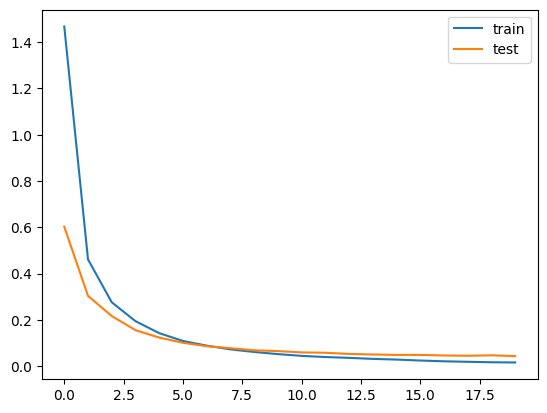

In [11]:
train(lenet5,optimizer, 
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 20)

Epoch : 0, accuracy: 0.8187999725341797
Epoch : 1, accuracy: 0.9010000228881836
Epoch : 2, accuracy: 0.9294000267982483
Epoch : 3, accuracy: 0.9415000081062317
Epoch : 4, accuracy: 0.9589999914169312
Epoch : 5, accuracy: 0.965399980545044
Epoch : 6, accuracy: 0.9700999855995178
Epoch : 7, accuracy: 0.9732999801635742
Epoch : 8, accuracy: 0.9764000177383423
Epoch : 9, accuracy: 0.9781000018119812
Epoch : 10, accuracy: 0.9787999987602234
Epoch : 11, accuracy: 0.9807000160217285
Epoch : 12, accuracy: 0.9817000031471252
Epoch : 13, accuracy: 0.982699990272522
Epoch : 14, accuracy: 0.9833999872207642
Epoch : 15, accuracy: 0.9818000197410583
Epoch : 16, accuracy: 0.9850999712944031
Epoch : 17, accuracy: 0.9830999970436096
Epoch : 18, accuracy: 0.9836000204086304
Epoch : 19, accuracy: 0.9843999743461609
Max test accuracy : 0.9850999712944031


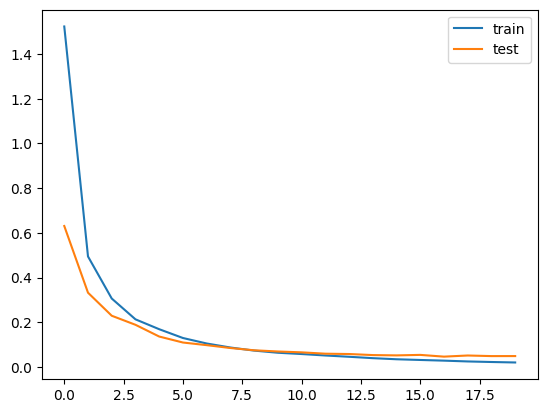

In [12]:
lenet5 = LeNet5(2,'tanh').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.1850000023841858
Epoch : 1, accuracy: 0.3296000063419342
Epoch : 2, accuracy: 0.6796000003814697
Epoch : 3, accuracy: 0.8194000124931335
Epoch : 4, accuracy: 0.8907999992370605
Epoch : 5, accuracy: 0.9311000108718872
Epoch : 6, accuracy: 0.9469000101089478
Epoch : 7, accuracy: 0.9569000005722046
Epoch : 8, accuracy: 0.9642999768257141
Epoch : 9, accuracy: 0.9699000120162964
Epoch : 10, accuracy: 0.973800003528595
Epoch : 11, accuracy: 0.9764999747276306
Epoch : 12, accuracy: 0.9794999957084656
Epoch : 13, accuracy: 0.9803000092506409
Epoch : 14, accuracy: 0.980400025844574
Epoch : 15, accuracy: 0.9824000000953674
Epoch : 16, accuracy: 0.9818999767303467
Epoch : 17, accuracy: 0.9818999767303467
Epoch : 18, accuracy: 0.9828000068664551
Epoch : 19, accuracy: 0.982699990272522
Max test accuracy : 0.9828000068664551


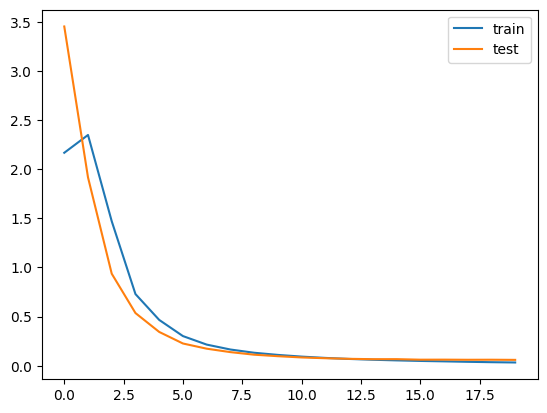

In [13]:
lenet5 = LeNet5(2,'relu').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.6363999843597412
Epoch : 1, accuracy: 0.8422999978065491
Epoch : 2, accuracy: 0.891700029373169
Epoch : 3, accuracy: 0.9254999756813049
Epoch : 4, accuracy: 0.9423999786376953
Epoch : 5, accuracy: 0.9545000195503235
Epoch : 6, accuracy: 0.9628000259399414
Epoch : 7, accuracy: 0.968999981880188
Epoch : 8, accuracy: 0.9717000126838684
Epoch : 9, accuracy: 0.9749000072479248
Epoch : 10, accuracy: 0.9767000079154968
Epoch : 11, accuracy: 0.979200005531311
Epoch : 12, accuracy: 0.9800999760627747
Epoch : 13, accuracy: 0.9799000024795532
Epoch : 14, accuracy: 0.9817000031471252
Epoch : 15, accuracy: 0.9829000234603882
Epoch : 16, accuracy: 0.9843000173568726
Epoch : 17, accuracy: 0.9839000105857849
Epoch : 18, accuracy: 0.9832000136375427
Epoch : 19, accuracy: 0.9847000241279602
Epoch : 20, accuracy: 0.9848999977111816
Epoch : 21, accuracy: 0.9858999848365784
Epoch : 22, accuracy: 0.9847999811172485
Epoch : 23, accuracy: 0.9865000247955322
Epoch : 24, accuracy: 0.98610

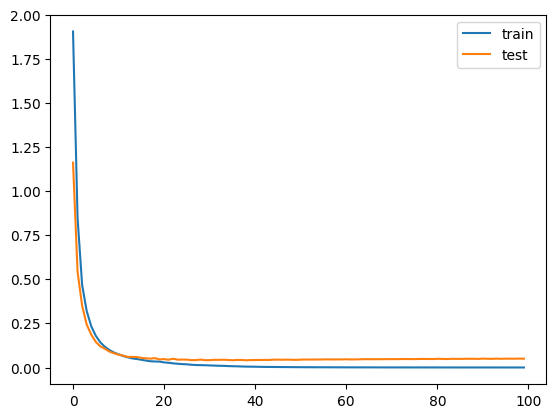

In [14]:
lenet5 = LeNet5(3).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Epoch : 0, accuracy: 0.34450000524520874
Epoch : 1, accuracy: 0.6294000148773193
Epoch : 2, accuracy: 0.7775999903678894
Epoch : 3, accuracy: 0.8324999809265137
Epoch : 4, accuracy: 0.8769999742507935
Epoch : 5, accuracy: 0.9071999788284302
Epoch : 6, accuracy: 0.9297999739646912
Epoch : 7, accuracy: 0.9417999982833862
Epoch : 8, accuracy: 0.9506000280380249
Epoch : 9, accuracy: 0.9563000202178955
Epoch : 10, accuracy: 0.9616000056266785
Epoch : 11, accuracy: 0.9664999842643738
Epoch : 12, accuracy: 0.9696000218391418
Epoch : 13, accuracy: 0.9729999899864197
Epoch : 14, accuracy: 0.9753000140190125
Epoch : 15, accuracy: 0.9767000079154968
Epoch : 16, accuracy: 0.978600025177002
Epoch : 17, accuracy: 0.9785000085830688
Epoch : 18, accuracy: 0.980400025844574
Epoch : 19, accuracy: 0.9797000288963318
Epoch : 20, accuracy: 0.9807999730110168
Epoch : 21, accuracy: 0.9807000160217285
Epoch : 22, accuracy: 0.980400025844574
Epoch : 23, accuracy: 0.9815000295639038
Epoch : 24, accuracy: 0.9833

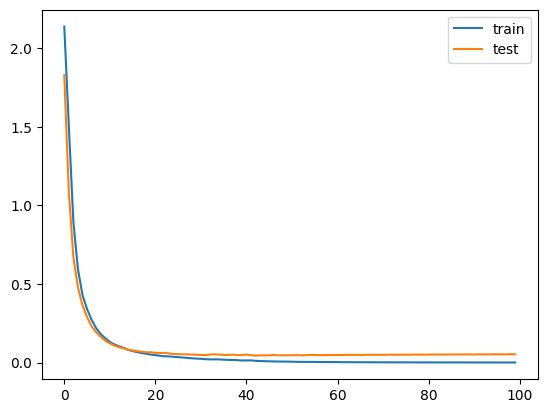

In [15]:
lenet5 = LeNet5(5).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Epoch : 0, accuracy: 0.07459999620914459
Epoch : 1, accuracy: 0.3960999846458435
Epoch : 2, accuracy: 0.5077999830245972
Epoch : 3, accuracy: 0.5281000137329102
Epoch : 4, accuracy: 0.6233999729156494
Epoch : 5, accuracy: 0.7026000022888184
Epoch : 6, accuracy: 0.767300009727478
Epoch : 7, accuracy: 0.8258999586105347
Epoch : 8, accuracy: 0.8418999910354614
Epoch : 9, accuracy: 0.8788999915122986
Epoch : 10, accuracy: 0.9138999581336975
Epoch : 11, accuracy: 0.9302999973297119
Epoch : 12, accuracy: 0.9440999627113342
Epoch : 13, accuracy: 0.9559999704360962
Epoch : 14, accuracy: 0.9613999724388123
Epoch : 15, accuracy: 0.9687999486923218
Epoch : 16, accuracy: 0.9702000021934509
Epoch : 17, accuracy: 0.971299946308136
Epoch : 18, accuracy: 0.9738999605178833
Epoch : 19, accuracy: 0.975600004196167
Epoch : 20, accuracy: 0.9768999814987183
Epoch : 21, accuracy: 0.9784999489784241
Epoch : 22, accuracy: 0.9775999784469604
Epoch : 23, accuracy: 0.977400004863739
Epoch : 24, accuracy: 0.97849

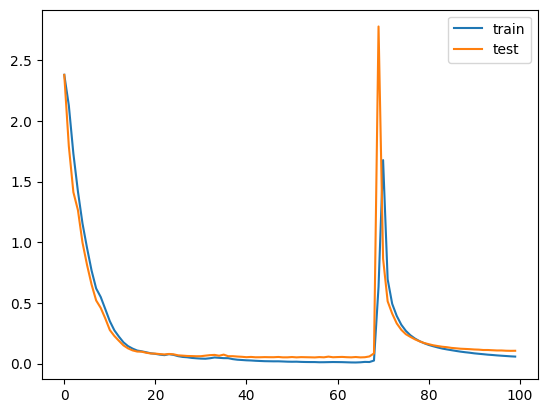

In [13]:
lenet5 = LeNet5(7).to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 100)

Epoch : 0, accuracy: 0.8184999823570251
Epoch : 1, accuracy: 0.9007999897003174
Epoch : 2, accuracy: 0.9302999973297119
Epoch : 3, accuracy: 0.9479999542236328
Epoch : 4, accuracy: 0.9583999514579773
Epoch : 5, accuracy: 0.9662999510765076
Epoch : 6, accuracy: 0.9708999991416931
Epoch : 7, accuracy: 0.9735999703407288
Epoch : 8, accuracy: 0.9764999747276306
Epoch : 9, accuracy: 0.9781999588012695
Epoch : 10, accuracy: 0.9802999496459961
Epoch : 11, accuracy: 0.9818999767303467
Epoch : 12, accuracy: 0.9833999872207642
Epoch : 13, accuracy: 0.9836999773979187
Epoch : 14, accuracy: 0.983199954032898
Epoch : 15, accuracy: 0.9843999743461609
Epoch : 16, accuracy: 0.9842999577522278
Epoch : 17, accuracy: 0.9846999645233154
Epoch : 18, accuracy: 0.9847999811172485
Epoch : 19, accuracy: 0.9864999651908875
Max test accuracy : 0.9864999651908875


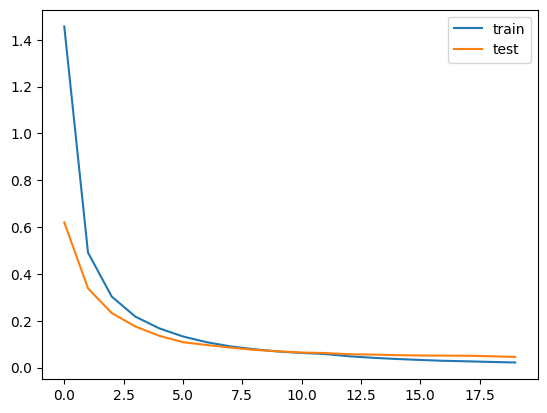

In [14]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.10099999606609344
Epoch : 1, accuracy: 0.11349999904632568
Epoch : 2, accuracy: 0.10089999437332153
Epoch : 3, accuracy: 0.11349999904632568
Epoch : 4, accuracy: 0.10319999605417252
Epoch : 5, accuracy: 0.10319999605417252
Epoch : 6, accuracy: 0.11349999904632568
Epoch : 7, accuracy: 0.0973999947309494
Epoch : 8, accuracy: 0.11349999904632568
Epoch : 9, accuracy: 0.1889999955892563
Epoch : 10, accuracy: 0.2629999816417694
Epoch : 11, accuracy: 0.37860000133514404
Epoch : 12, accuracy: 0.4456000030040741
Epoch : 13, accuracy: 0.5745999813079834
Epoch : 14, accuracy: 0.6247000098228455
Epoch : 15, accuracy: 0.6714000105857849
Epoch : 16, accuracy: 0.698199987411499
Epoch : 17, accuracy: 0.7597000002861023
Epoch : 18, accuracy: 0.8057999610900879
Epoch : 19, accuracy: 0.788100004196167
Max test accuracy : 0.8057999610900879


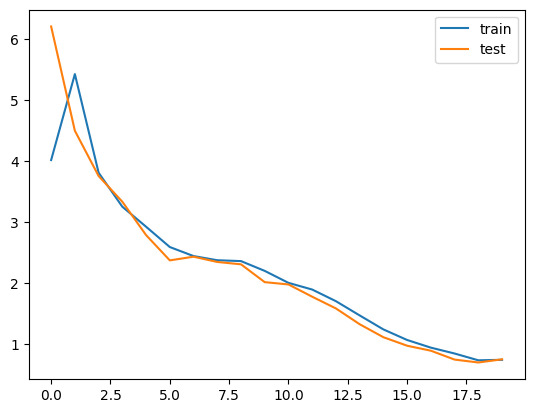

In [15]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.1)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

In [ ]:
Изменение шага lr в 10 раз дало увеличение точности на 2%

Epoch : 0, accuracy: 0.7249000072479248
Epoch : 1, accuracy: 0.7994999885559082
Epoch : 2, accuracy: 0.8671999573707581
Epoch : 3, accuracy: 0.9121999740600586
Epoch : 4, accuracy: 0.9332999587059021
Epoch : 5, accuracy: 0.949999988079071
Epoch : 6, accuracy: 0.9596999883651733
Epoch : 7, accuracy: 0.9666000008583069
Epoch : 8, accuracy: 0.9700999855995178
Epoch : 9, accuracy: 0.9726999998092651
Epoch : 10, accuracy: 0.9756999611854553
Epoch : 11, accuracy: 0.9768999814987183
Epoch : 12, accuracy: 0.9783999919891357
Epoch : 13, accuracy: 0.9812999963760376
Epoch : 14, accuracy: 0.9803999662399292
Epoch : 15, accuracy: 0.9818999767303467
Epoch : 16, accuracy: 0.9830999970436096
Epoch : 17, accuracy: 0.9836999773979187
Epoch : 18, accuracy: 0.9842999577522278
Epoch : 19, accuracy: 0.9848999977111816
Max test accuracy : 0.9848999977111816


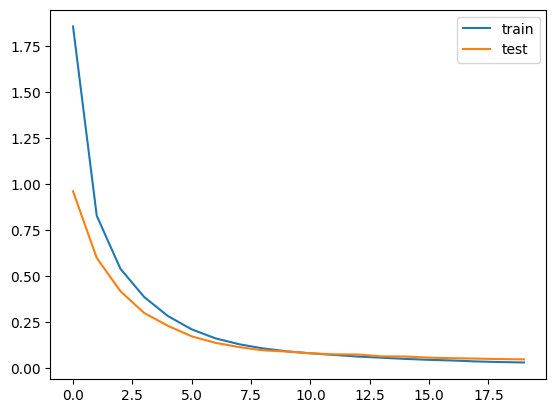

In [16]:
lenet5 = LeNet5(3,'tanh', 'average').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

Epoch : 0, accuracy: 0.7918999791145325
Epoch : 1, accuracy: 0.8914999961853027
Epoch : 2, accuracy: 0.9275999665260315
Epoch : 3, accuracy: 0.9497999548912048
Epoch : 4, accuracy: 0.9583999514579773
Epoch : 5, accuracy: 0.9642999768257141
Epoch : 6, accuracy: 0.9679999947547913
Epoch : 7, accuracy: 0.9740999937057495
Epoch : 8, accuracy: 0.9768999814987183
Epoch : 9, accuracy: 0.9786999821662903
Epoch : 10, accuracy: 0.9787999987602234
Epoch : 11, accuracy: 0.9803999662399292
Epoch : 12, accuracy: 0.9805999994277954
Epoch : 13, accuracy: 0.9812999963760376
Epoch : 14, accuracy: 0.9810999631881714
Epoch : 15, accuracy: 0.9820999503135681
Epoch : 16, accuracy: 0.9824000000953674
Epoch : 17, accuracy: 0.983199954032898
Epoch : 18, accuracy: 0.9828999638557434
Epoch : 19, accuracy: 0.9837999939918518
Max test accuracy : 0.9837999939918518


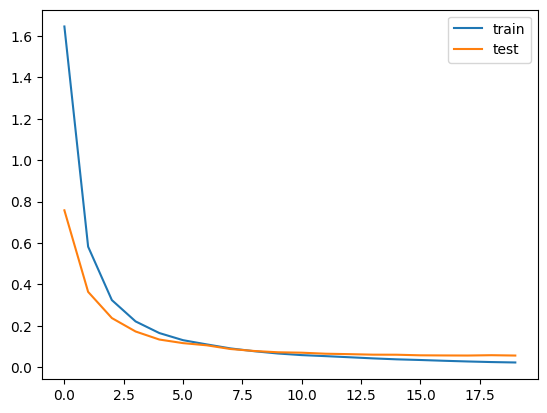

In [17]:
lenet5 = LeNet5(3,'tanh', 'max').to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 10240,
        n_epochs = 20)

In [ ]:
Разница между типами пулинга не дала заметного прироста точности

Задание 4

Epoch : 0, accuracy: 0.9088999629020691
Epoch : 1, accuracy: 0.9458999633789062
Epoch : 2, accuracy: 0.9673999547958374
Epoch : 3, accuracy: 0.9746999740600586
Epoch : 4, accuracy: 0.9799000024795532
Epoch : 5, accuracy: 0.9817999601364136
Epoch : 6, accuracy: 0.9829999804496765
Epoch : 7, accuracy: 0.9861999750137329
Epoch : 8, accuracy: 0.9839999675750732
Epoch : 9, accuracy: 0.9847999811172485
Epoch : 10, accuracy: 0.9863999485969543
Epoch : 11, accuracy: 0.9860000014305115
Epoch : 12, accuracy: 0.9866999983787537
Epoch : 13, accuracy: 0.9860999584197998
Epoch : 14, accuracy: 0.9868999719619751
Epoch : 15, accuracy: 0.9872999787330627
Epoch : 16, accuracy: 0.9875999689102173
Epoch : 17, accuracy: 0.988099992275238
Epoch : 18, accuracy: 0.9869999885559082
Epoch : 19, accuracy: 0.988599956035614
Max test accuracy : 0.988599956035614
Epoch : 0, accuracy: 0.9172000288963318
Epoch : 1, accuracy: 0.9589999914169312
Epoch : 2, accuracy: 0.9708999991416931
Epoch : 3, accuracy: 0.97750002145

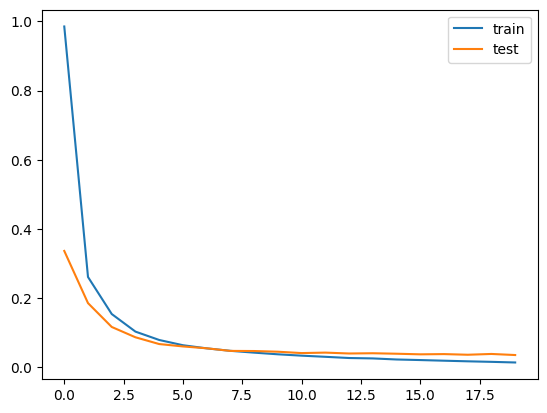

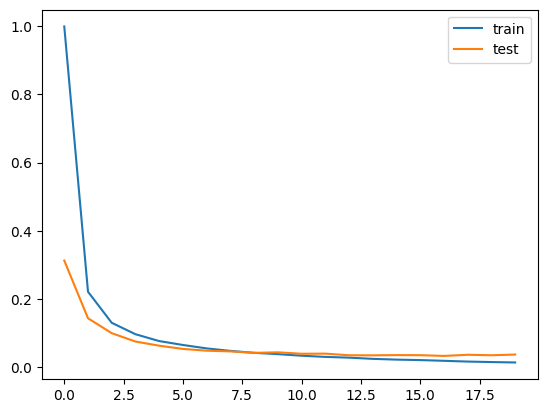

In [18]:
from time import time
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)
start_gpu = time()

train(lenet5,optimizer,
        X_train,y_train,
        X_test,y_test, 
        device, 
        batch_size = 1024,
        n_epochs = 20)
finish_gpu = time()

lenet5 = LeNet5().to('cpu')
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

start_cpu = time()
train(lenet5,optimizer,
      X_train.cpu(),y_train.cpu(),
      X_test.cpu(),y_test.cpu(), 
      'cpu', 
      batch_size = 1024,
      n_epochs = 20)

finish_cpu = time()

print(f'gpu training takes {finish_gpu - start_gpu}')
print(f'cpu training takes {finish_cpu - start_cpu}')

In [ ]:
Время тренировки на GPU в 12 раз меньше времени тренировки на CPU

Задание 5

Epoch : 0, accuracy: 0.8305000066757202
Epoch : 1, accuracy: 0.9043999910354614
Epoch : 2, accuracy: 0.9366999864578247
Epoch : 3, accuracy: 0.9549999833106995
Epoch : 4, accuracy: 0.9688999652862549
Epoch : 5, accuracy: 0.9713999629020691
Epoch : 6, accuracy: 0.9765999913215637
Epoch : 7, accuracy: 0.9819999933242798
Epoch : 8, accuracy: 0.983299970626831
Epoch : 9, accuracy: 0.9842000007629395
Epoch : 10, accuracy: 0.9853000044822693
Epoch : 11, accuracy: 0.9845999479293823
Epoch : 12, accuracy: 0.9866999983787537
Epoch : 13, accuracy: 0.9874999523162842
Epoch : 14, accuracy: 0.9869999885559082
Epoch : 15, accuracy: 0.9871999621391296
Epoch : 16, accuracy: 0.9858999848365784
Epoch : 17, accuracy: 0.9875999689102173
Epoch : 18, accuracy: 0.9878999590873718
Epoch : 19, accuracy: 0.9879999756813049
Epoch : 20, accuracy: 0.988099992275238
Epoch : 21, accuracy: 0.988599956035614
Epoch : 22, accuracy: 0.9866999983787537
Epoch : 23, accuracy: 0.9886999726295471
Epoch : 24, accuracy: 0.98649

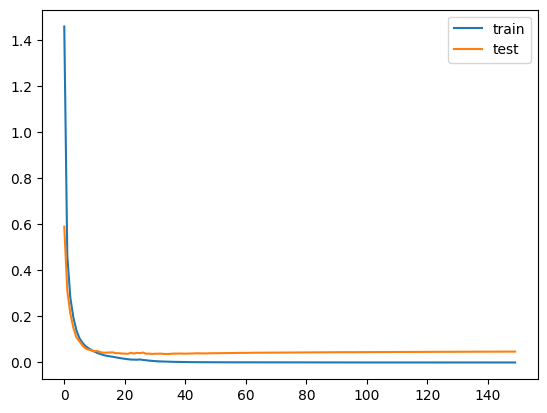

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)

train(lenet5,optimizer, 
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 150)

In [ ]:
Задание 6

Epoch : 0, accuracy: 0.7364999651908875
Epoch : 1, accuracy: 0.8807999491691589
Epoch : 2, accuracy: 0.9152999520301819
Epoch : 3, accuracy: 0.9417999982833862
Epoch : 4, accuracy: 0.9576999545097351
Epoch : 5, accuracy: 0.9657999873161316
Epoch : 6, accuracy: 0.972599983215332
Epoch : 7, accuracy: 0.9768999814987183
Epoch : 8, accuracy: 0.9783999919891357
Epoch : 9, accuracy: 0.9807999730110168
Epoch : 10, accuracy: 0.9813999533653259
Epoch : 11, accuracy: 0.9829999804496765
Epoch : 12, accuracy: 0.9835000038146973
Epoch : 13, accuracy: 0.9853999614715576
Epoch : 14, accuracy: 0.98499995470047
Epoch : 15, accuracy: 0.9864999651908875
Epoch : 16, accuracy: 0.9863999485969543
Epoch : 17, accuracy: 0.9861999750137329
Epoch : 18, accuracy: 0.9871999621391296
Epoch : 19, accuracy: 0.9883999824523926
Epoch : 20, accuracy: 0.9874999523162842
Epoch : 21, accuracy: 0.9875999689102173
Epoch : 22, accuracy: 0.9870999455451965
Epoch : 23, accuracy: 0.9873999953269958
Epoch : 24, accuracy: 0.98729

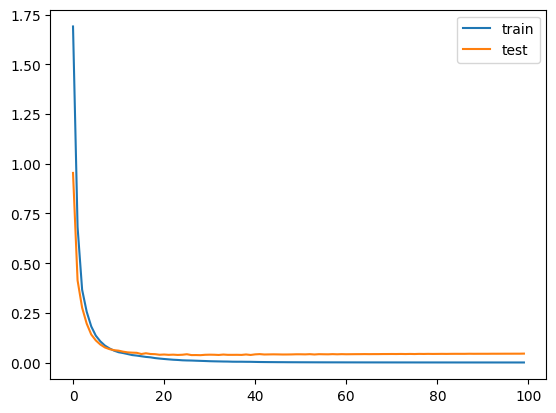

In [20]:
lenet5 = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01)
start_gpu = time()

train(lenet5,optimizer,
    X_train,y_train,
    X_test,y_test, 
    device, 
    batch_size = 10240,
    n_epochs = 100)

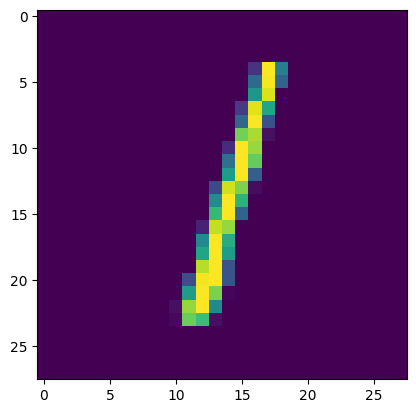

tensor(1)


In [21]:
plt.imshow(X_test[2][0].cpu())
plt.show()
print(y_test[2])

In [22]:
lenet5.forward(X_test[2].unsqueeze(0).cuda()).argmax(1).item()

1

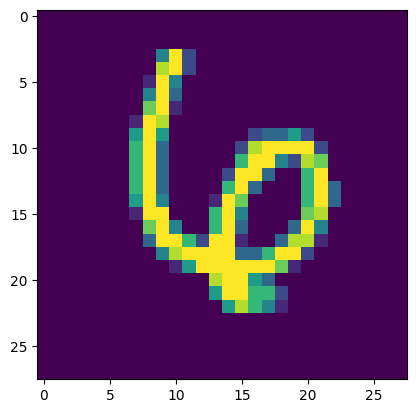

tensor(6)


6

In [23]:
plt.imshow(X_test[22][0].cpu())
plt.show()
print(y_test[22])

lenet5.forward(X_test[22].unsqueeze(0).cuda()).argmax(1).item()